In [1]:
# Mount Google Drive to save checkpoints and results
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries (optional if already installed in Colab)
!pip install tensorflow
!pip install matplotlib
!pip install Pillow


Mounted at /content/drive


In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv /content/kaggle.json /root/.kaggle/
os.chmod('/root/.kaggle/kaggle.json', 600)


In [ ]:
!kaggle datasets list


ref                                                              title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset      Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          21491        445  1.0              
muhammadroshaanriaz/students-performance-dataset-cleaned         Students Performance | Clean Dataset            10KB  2024-10-29 19:32:26           2157         45  1.0              
valakhorasani/gym-members-exercise-dataset                       Gym Members Exercise Dataset                    22KB  2024-10-06 11:27:38          12224        181  1.0              
jahnavipaliwal/customer-feedback-and-satisfaction                Customer Feedba

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/dcgan_data --unzip


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.32G/1.33G [00:16<00:00, 32.0MB/s]
100% 1.33G/1.33G [00:16<00:00, 85.7MB/s]


In [ ]:
# 重新下載並解壓 CelebA 數據集
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/dcgan_data --unzip


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:02<00:00, 24.1MB/s]
100% 1.33G/1.33G [01:02<00:00, 22.9MB/s]


In [4]:
import os

image_folder = '/content/dcgan_data/img_align_celeba/img_align_celeba'
num_images = len([name for name in os.listdir(image_folder) if name.endswith('.jpg')])
print(f"Number of images in dataset: {num_images}")


Number of images in dataset: 202599


Epoch 10, Generator Loss: 1.0935, Discriminator Loss: 1.2608


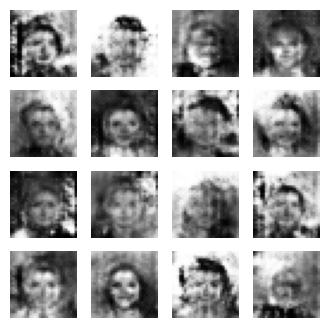

Epoch 20, Generator Loss: 1.1231, Discriminator Loss: 1.2646


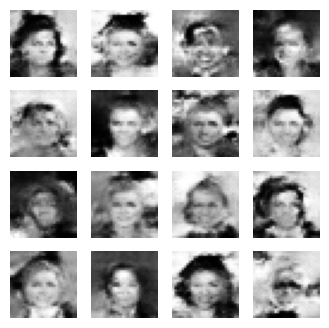

Epoch 30, Generator Loss: 1.0895, Discriminator Loss: 1.1808


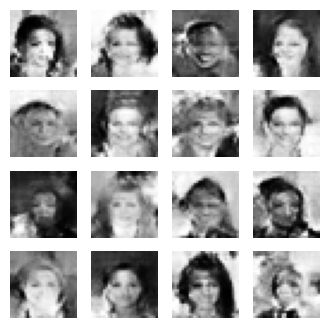

Epoch 40, Generator Loss: 0.9155, Discriminator Loss: 1.3716


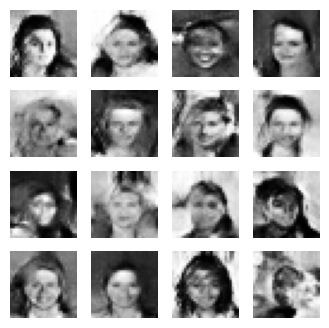

Epoch 50, Generator Loss: 0.9943, Discriminator Loss: 1.2519


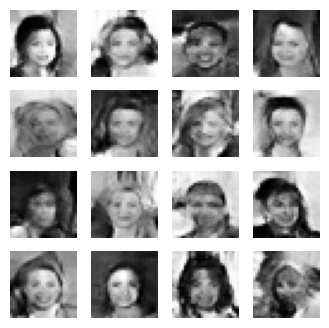

Epoch 60, Generator Loss: 1.0009, Discriminator Loss: 1.2154


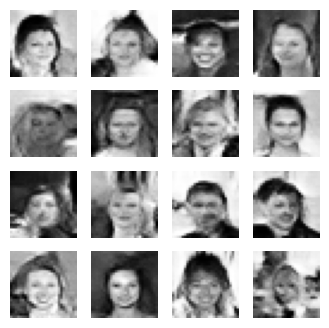

Epoch 70, Generator Loss: 0.9932, Discriminator Loss: 1.3848


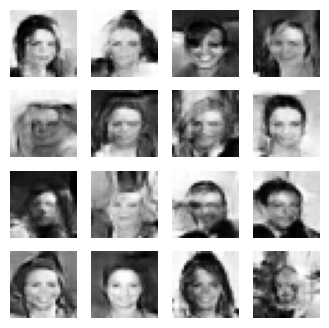

Epoch 80, Generator Loss: 0.9634, Discriminator Loss: 1.2765


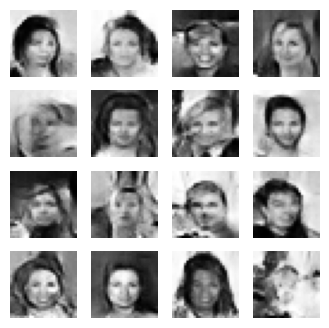

Epoch 90, Generator Loss: 0.9862, Discriminator Loss: 1.3264


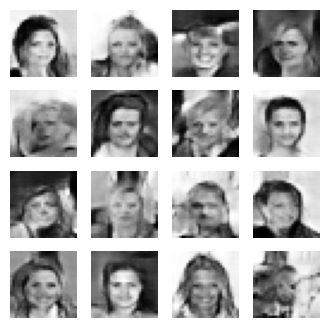

Epoch 100, Generator Loss: 0.9540, Discriminator Loss: 1.2854


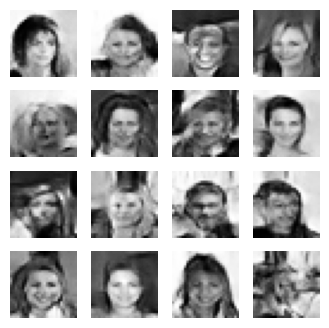

Epoch 110, Generator Loss: 0.8980, Discriminator Loss: 1.3734


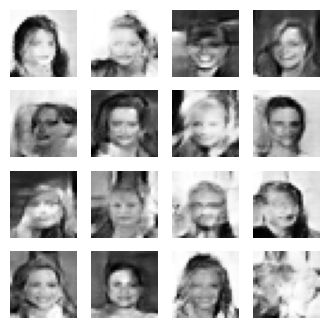

Epoch 120, Generator Loss: 0.9444, Discriminator Loss: 1.3098


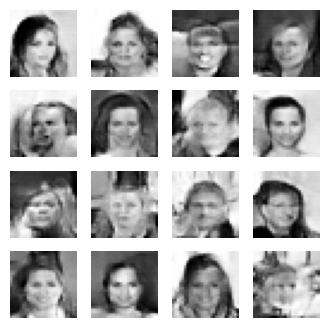

Epoch 130, Generator Loss: 0.9035, Discriminator Loss: 1.3411


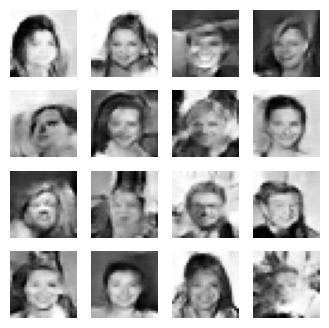

Epoch 140, Generator Loss: 0.8843, Discriminator Loss: 1.4304


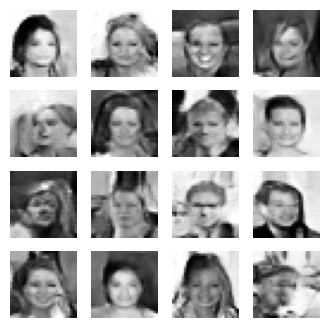

Epoch 150, Generator Loss: 0.9097, Discriminator Loss: 1.3462


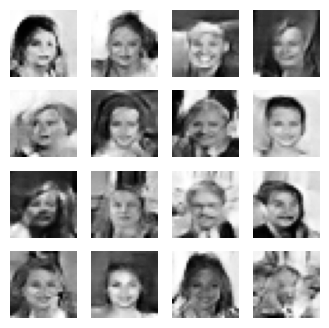

Epoch 160, Generator Loss: 0.8961, Discriminator Loss: 1.3507


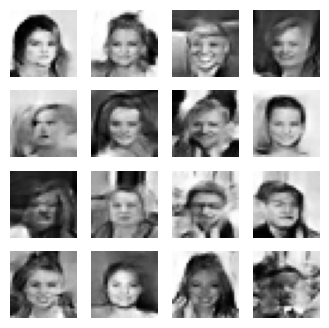

Epoch 170, Generator Loss: 0.8208, Discriminator Loss: 1.4212


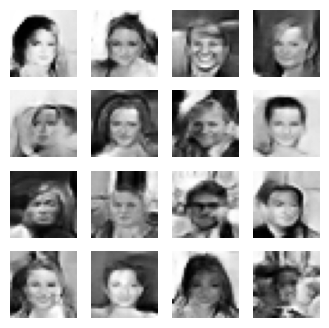

Epoch 180, Generator Loss: 0.9164, Discriminator Loss: 1.2700


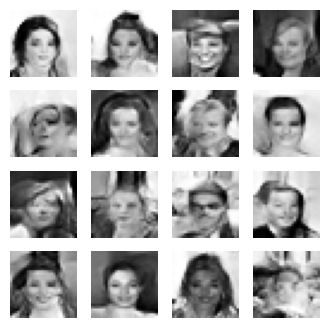

Epoch 190, Generator Loss: 0.9057, Discriminator Loss: 1.3306


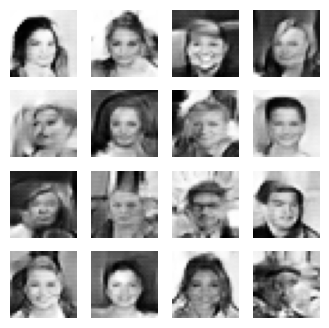

Epoch 200, Generator Loss: 0.8930, Discriminator Loss: 1.3083


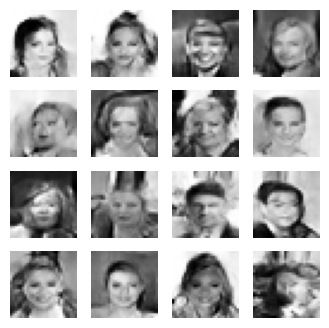

Epoch 210, Generator Loss: 0.8580, Discriminator Loss: 1.3190


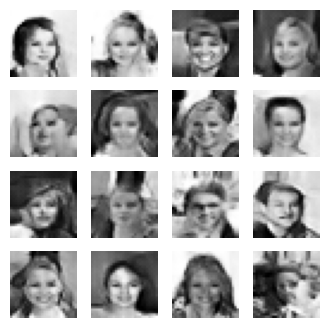

Epoch 220, Generator Loss: 0.8127, Discriminator Loss: 1.3992


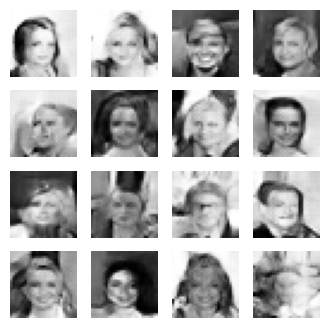

Epoch 230, Generator Loss: 0.8669, Discriminator Loss: 1.2915


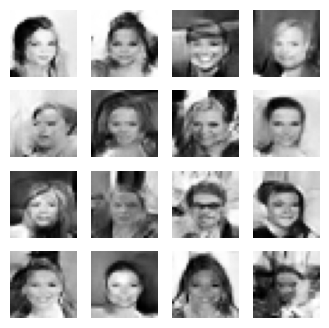

Epoch 240, Generator Loss: 0.9766, Discriminator Loss: 1.2985


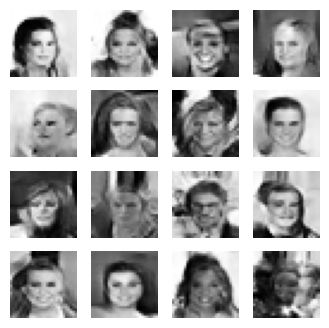

Epoch 250, Generator Loss: 0.9104, Discriminator Loss: 1.2900


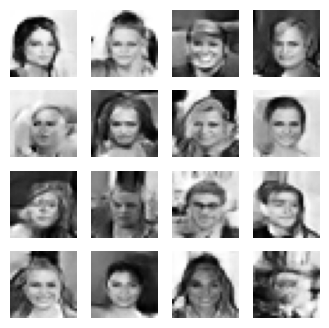

Epoch 260, Generator Loss: 0.9015, Discriminator Loss: 1.3136


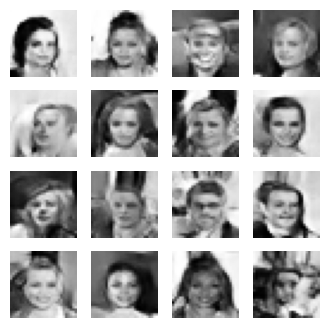

Epoch 270, Generator Loss: 0.8971, Discriminator Loss: 1.3281


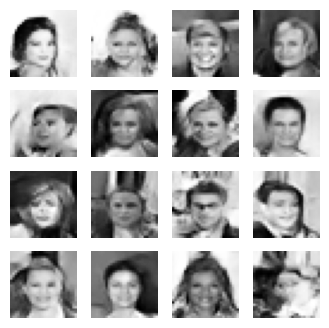

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# 設定資料夾路徑
image_folder = '/content/dcgan_data/img_align_celeba/img_align_celeba'

# 設定參數
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 300
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# 訓練時使用固定的種子，以便於比較生成結果
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Google Drive 路徑，用於保存模型和結果
save_dir = '/content/drive/MyDrive/dcgan_training'
os.makedirs(save_dir, exist_ok=True)

# 加載 CelebA 數據集並進行預處理
def load_celebA_images(data_dir, image_size=(28, 28)):
    images = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("L")
            img = img.resize(image_size)
            img = (np.array(img) - 127.5) / 127.5
            images.append(img)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)
    return images

# 加載數據
train_images = load_celebA_images(image_folder)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 定義生成器和判別器
def build_generator():
    model = Sequential([
        Input(shape=(NOISE_DIM,)),
        Dense(7 * 7 * 256, use_bias=False, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4)),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4)),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

# 初始化生成器和判別器
generator = build_generator()
discriminator = build_discriminator()

# 定義損失和優化器
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 調整學習率
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 訓練步驟和損失曲線
gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 保存模型和損失曲線
def save_checkpoint_and_plot(epoch):
    generator.save(f"{save_dir}/generator_epoch_{epoch}.keras")
    discriminator.save(f"{save_dir}/discriminator_epoch_{epoch}.keras")

    plt.figure()
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{save_dir}/loss_curve_epoch_{epoch}.png")
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss, disc_loss = 0.0, 0.0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
            generate_and_save_images(generator, epoch + 1, seed)
            save_checkpoint_and_plot(epoch + 1)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f"{save_dir}/image_at_epoch_{epoch:04d}.png")
    plt.show()

# 開始訓練
train(train_dataset, EPOCHS)


In [ ]:
# 壓縮文件夾
!zip -r /content/dcgan_training.zip /content/drive/MyDrive/dcgan_training


  adding: content/drive/MyDrive/dcgan_training/ (stored 0%)
  adding: content/drive/MyDrive/dcgan_training/image_at_epoch_0010.png (deflated 3%)
  adding: content/drive/MyDrive/dcgan_training/generator_epoch_10.h5 (deflated 12%)
  adding: content/drive/MyDrive/dcgan_training/discriminator_epoch_10.h5 (deflated 11%)
  adding: content/drive/MyDrive/dcgan_training/loss_curve_epoch_10.png (deflated 10%)
  adding: content/drive/MyDrive/dcgan_training/image_at_epoch_0020.png (deflated 3%)
  adding: content/drive/MyDrive/dcgan_training/generator_epoch_20.h5 (deflated 12%)
  adding: content/drive/MyDrive/dcgan_training/discriminator_epoch_20.h5 (deflated 11%)
  adding: content/drive/MyDrive/dcgan_training/loss_curve_epoch_20.png (deflated 10%)
  adding: content/drive/MyDrive/dcgan_training/image_at_epoch_0030.png (deflated 3%)
  adding: content/drive/MyDrive/dcgan_training/generator_epoch_30.h5 (deflated 12%)
  adding: content/drive/MyDrive/dcgan_training/discriminator_epoch_30.h5 (deflated 11

Epoch 10, Generator Loss: 0.9392, Discriminator Loss: 1.2396


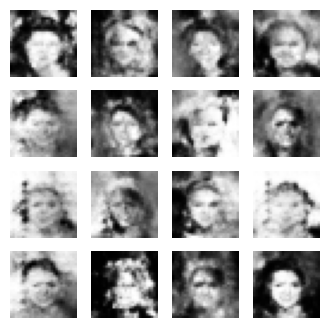

Epoch 20, Generator Loss: 0.8387, Discriminator Loss: 1.2881


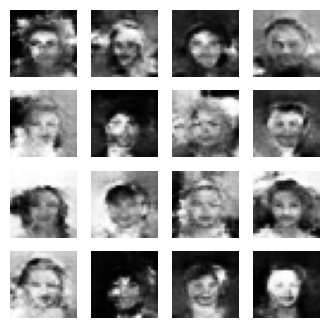

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# 設定資料夾路徑
image_folder = '/content/dcgan_data/img_align_celeba/img_align_celeba'

# 設定參數
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 300
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# 訓練時使用固定的種子，以便於比較生成結果
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Google Drive 路徑，用於保存模型和結果
save_dir = '/content/drive/MyDrive/dcgan_training'
os.makedirs(save_dir, exist_ok=True)

# 加載 CelebA 數據集並進行預處理
def load_celebA_images(data_dir, image_size=(28, 28)):
    images = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("L")
            img = img.resize(image_size)
            img = (np.array(img) - 127.5) / 127.5
            images.append(img)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)
    return images

# 加載數據
train_images = load_celebA_images(image_folder)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 定義生成器和判別器
def build_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model

# 初始化生成器和判別器
generator = build_generator()
discriminator = build_discriminator()

# 定義損失和優化器，降低學習率
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 調整學習率
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 訓練步驟和損失曲線
gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 保存模型和損失曲線
def save_checkpoint_and_plot(epoch):
    # 保存模型為 .keras 格式
    generator.save(f"{save_dir}/generator_epoch_{epoch}.keras")
    discriminator.save(f"{save_dir}/discriminator_epoch_{epoch}.keras")

    # 繪製損失曲線
    plt.figure()
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{save_dir}/loss_curve_epoch_{epoch}.png")
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        # 初始化損失值
        gen_loss = 0.0
        disc_loss = 0.0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        # 每 10 個 epoch 保存模型和視覺化結果
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
            generate_and_save_images(generator, epoch + 1, seed)
            save_checkpoint_and_plot(epoch + 1)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f"{save_dir}/image_at_epoch_{epoch:04d}.png")
    plt.show()

# 開始訓練
train(train_dataset, EPOCHS)
